<a href="https://colab.research.google.com/github/ArtAnichkin/msuai-hw/blob/main/EX09_RNN_%D0%90%D0%BD%D0%B8%D1%87%D0%BA%D0%B8%D0%BD_%D0%90%D1%80%D1%82%D0%B5%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 1. RNN, LSTM и GRU

Используя код из лекции, попробуйте обучить RNN с размерностью скрытого состояния `hidden_size=2` на следующих периодичных данных и визуализируйте результат.

In [ ]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn

import random
import torch


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

In [ ]:
input_size = 1
hidden_size = 2

Функция для визуализации на базе материала из лекции:

In [ ]:
def display(data, pred=None, vert=None, title="Prediction"):
    data = np.array(data).reshape((len(data), 1))
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Some periodic function")
    if pred is not None:
        plt.plot(pred, label=title)
    if vert is not None:
        plt.axvline(x=vert, c="r", linestyle="--")
    plt.legend()
    plt.grid()
    plt.show()

Генерация данных для обучения:

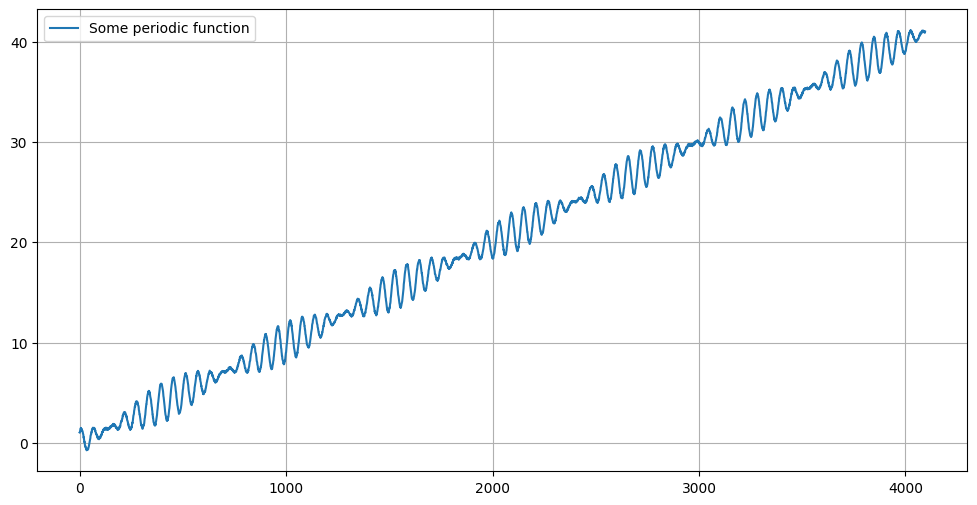

In [ ]:
training_data = []
for i in range(4096):
    training_data.append(
        math.sin(i / 10) + math.cos((i) / 9) + i / 100 + (random.random() - 0.5) / 5
    )

display(training_data)

**Подготовка данных**

Данные имеют ярко выраженный линейный тренд
"A time series with a trend is called non-stationary."
https://machinelearningmastery.com/time-series-trends-in-python/

Удалим его, используя функцию [detrend](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) из `scipy.signal`.

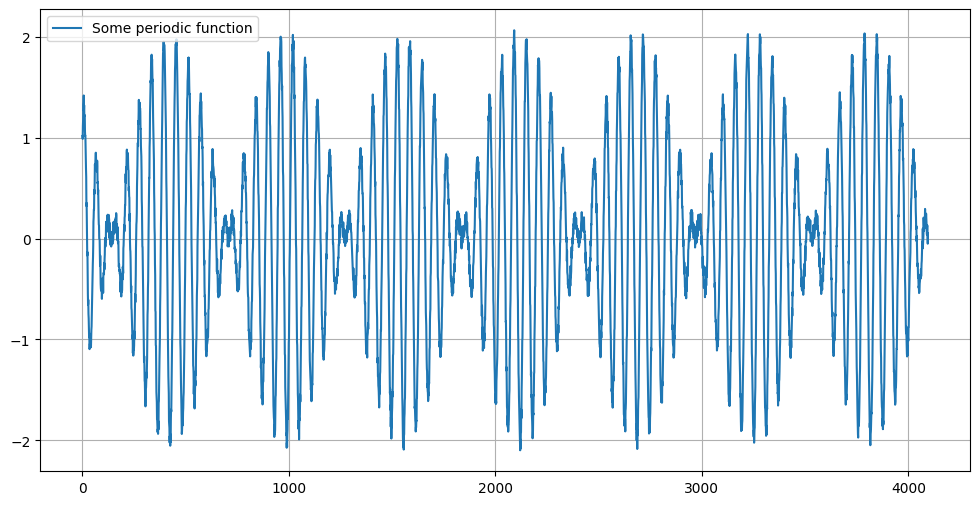

In [ ]:
from scipy.signal import detrend

stationary_data = detrend(training_data)
display(stationary_data)

Сохраним тренд, чтобы иметь возможность восстановить данные:

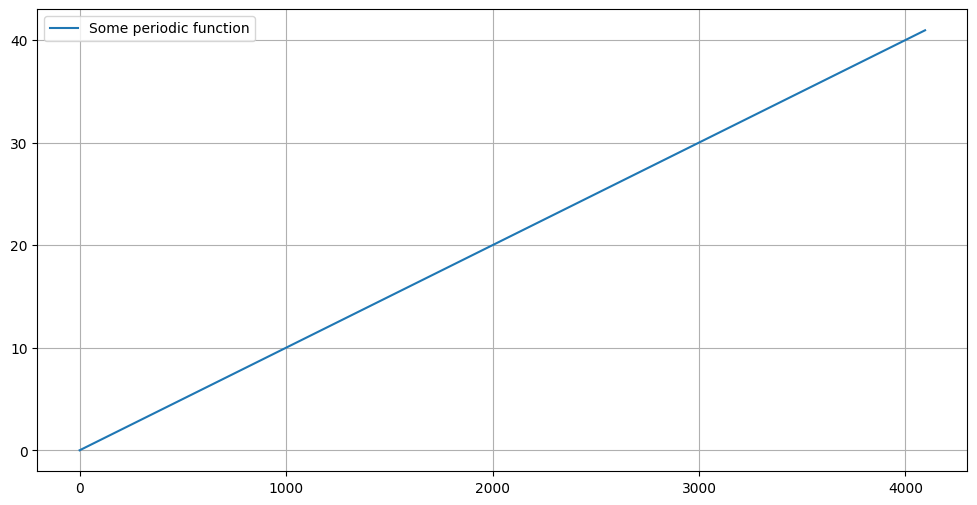

In [ ]:
trend = training_data - stationary_data
display(trend)

Теперь следовало бы стандартизовать данные. Но для наших данных среднее равно нулю, а дисперсия — почти единица, так что этот шаг можено опустить.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(stationary_data.reshape(-1,1)).reshape(1,-1)

array([[ 1.02493185,  0.99546601,  1.12701942, ...,  0.01216706,
        -0.05147986,  0.05147629]])

In [ ]:
stationary_data

array([ 1.01610472,  0.98689265,  1.11731307, ...,  0.01206227,
       -0.0510365 ,  0.05103296])

Данные отличаются не сильно, поэтому опустим этот шаг

Обучите на этих данных модель с простым RNN слоем и визуализируйте результат.

* Отметьте, что для обучения моделей вам **нужно использовать `stationary_data`**. Если вы будете использовать данные, в котором есть тренд, и при этом не произведёте нормировку данных, то вашей модели потребуется выучить операцию нормировки самостоятельно. Для этого потребуется много больше эпох и нейронов.

* Для того, чтобы избежать утечки в данных, каждая ваша подвыборка не должна заглядывать в прошлое. Так, если вы разделили вашу тренировочную подвыборку на N интервалов длиной `seq_len` и предсказываете элемент, идущий за `seq_len`, то по нулевому интервалу вы предсказываете данные в первом интервале и т.д. А вот предсказать объекты в интервале на позиции `0` не из чего.

На базе кода из лекции создадим модель:

In [ ]:
import torch
import torch.nn as nn


class Predictor(nn.Module):
    def __init__(self, input_size, hidden_size, cell=nn.RNN):
        super().__init__()
        self.cell = cell(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, h = self.cell(x)
        y = self.fc(h)
        return y

class Predictor_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, cell=nn.LSTM):
        super().__init__()
        self.cell = cell(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (h, m) = self.cell(x)
        y = self.fc(h)
        return y

И поместим данные в стандартные PyTorch Dataset и Dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split


class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length=8):  # sequence length 8->1
        super().__init__()
        self.seq_length = seq_length
        self.data = torch.from_numpy(data).to(torch.float)

    def __getitem__(self, n):
        x = self.data[n : (n + self.seq_length)]  # seq_len * elements
        y = self.data[n + self.seq_length]  # one element
        return x.unsqueeze(1), y

    def __len__(self):
        return len(self.data) - self.seq_length


train_size = int(len(stationary_data) * 0.8)
train_set = TimeSeriesDataset(stationary_data[:train_size])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)

val_set = TimeSeriesDataset(stationary_data[train_size:])
val_loader = DataLoader(val_set, batch_size=32, drop_last=True)

In [ ]:
def time_series_train(model, num_epochs=101, learning_rate=0.01):
    criterion = torch.nn.MSELoss()  # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        avg_train_loss = 0
        for batch in train_loader:
            x, y = batch
            y_pred = model(x)  # we don't use h there, but we can!
            loss = criterion(y_pred.flatten(), y.flatten())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            avg_train_loss += loss / len(train_loader)

        if epoch % 15 == 0:
            print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (avg_train_loss))

In [ ]:
def eval_model(model, loader):
    y_pred_list = []
    rnn.eval()
    for batch in loader:
        x, y = batch
        y_pred = model(x)
        y_pred_list.append(y_pred.flatten())
    return torch.cat(y_pred_list, 0).detach().numpy()

In [ ]:
def time_series_plot(train_predict, real, test_predict, seq_length=8):
    train_predict = train_predict
    test_predict = test_predict
    y_data_plot = real

    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(y_data_plot.shape[0]), y_data_plot)################

    plt.plot(seq_length + np.arange(train_predict.shape[0]), train_predict)
    #print (seq_length +1 + np.arange(train_predict.shape[0]))
    plt.axvline(x=train_size, c="r", linestyle="--")
    plt.plot(train_size + seq_length + np.arange(test_predict.shape[0]), test_predict)

    #print (train_size +1 + seq_length + np.arange(test_predict.shape[0]))

    plt.axvline(x=len(real.data), c="r", linestyle="--")
    #print (len(real.data))

    plt.title("Number of passengers per month")
    plt.ylabel("#passengers")
    plt.xlabel("Month")

    plt.legend(["Real", "Train Predicted", "Train/Test separation", "Test Predicted"])
    plt.grid(axis="x")
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

def get_val_mse(stationary_data, test_predict):
    return mean_squared_error(test_predict, stationary_data[train_size:-20])

Обучите модель.
Вам потребуется примерно 100-300 эпох, чтобы добиться ошибки порядка 0.03 по MSELoss.

In [ ]:
input_size = 1
hidden_size = 8
rnn = Predictor(input_size, hidden_size, cell=nn.RNN)
time_series_train(rnn)

Epoch: 0,       loss: 0.08774
Epoch: 15,      loss: 0.01120
Epoch: 30,      loss: 0.01303
Epoch: 45,      loss: 0.00813
Epoch: 60,      loss: 0.00967
Epoch: 75,      loss: 0.00819
Epoch: 90,      loss: 0.01080


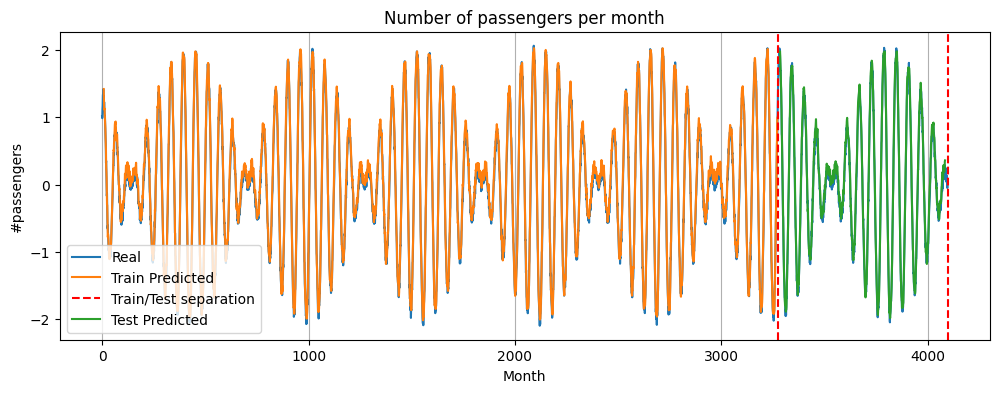

In [ ]:
train_predict = eval_model(rnn, train_loader)
test_predict = eval_model(rnn, val_loader)

time_series_plot(train_predict, stationary_data, test_predict)

In [ ]:
get_val_mse(stationary_data, test_predict)

0.6962623462813802

Теперь обучите на этих же данных LSTM с таким же размером скрытого слоя и визуализируйте результат.

In [ ]:
input_size = 1
hidden_size = 8
lstm = Predictor_LSTM(input_size, hidden_size, cell=nn.LSTM)
time_series_train(lstm)

Epoch: 0,       loss: 0.16126
Epoch: 15,      loss: 0.00688
Epoch: 30,      loss: 0.00635
Epoch: 45,      loss: 0.00677
Epoch: 60,      loss: 0.00650
Epoch: 75,      loss: 0.00655
Epoch: 90,      loss: 0.00637


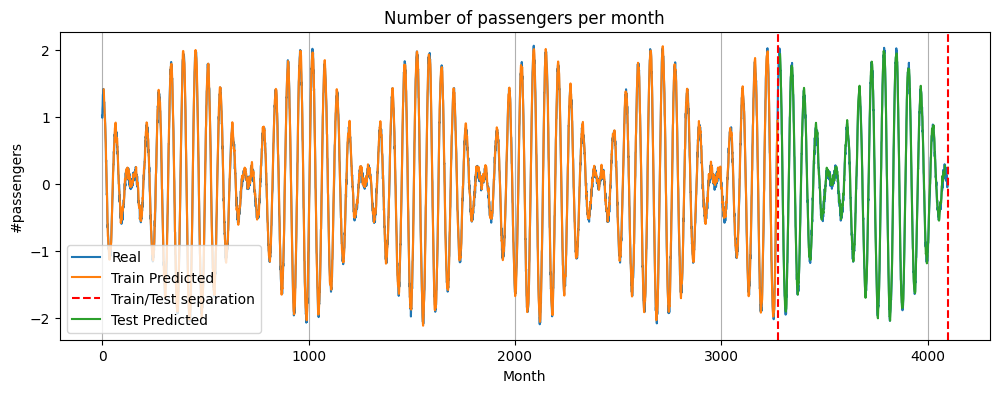

In [ ]:
train_predict = eval_model(lstm, train_loader)
test_predict = eval_model(lstm, val_loader)

time_series_plot(train_predict, stationary_data, test_predict)

In [ ]:
get_val_mse(stationary_data, test_predict)

0.6791395874776908

Произведите аналогичные действия с GRU моделью.

In [ ]:
input_size = 1
hidden_size = 8
gru = Predictor(input_size, hidden_size, cell=nn.GRU)
time_series_train(gru)

Epoch: 0,       loss: 0.12032
Epoch: 15,      loss: 0.00783
Epoch: 30,      loss: 0.01002
Epoch: 45,      loss: 0.00733
Epoch: 60,      loss: 0.00581
Epoch: 75,      loss: 0.00663
Epoch: 90,      loss: 0.00721


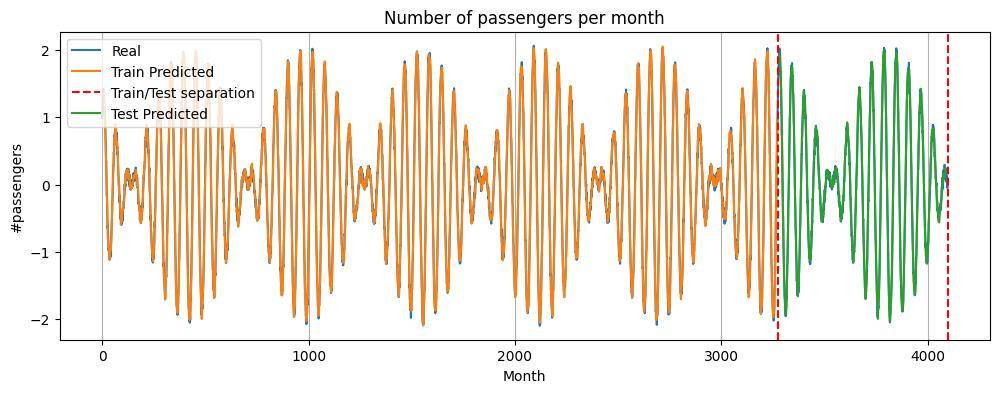

In [ ]:
train_predict = eval_model(gru, train_loader)
test_predict = eval_model(gru, val_loader)

time_series_plot(train_predict, stationary_data, test_predict)

In [ ]:
get_val_mse(stationary_data, test_predict)

0.6785766224457412



Сравните результаты и скорость работы RNN, LSTM и GRU.

По времени все модели фитятся примерно одинаково. Метрики почти одинаковые, по качеству выстраивается ряд: lstm, gru, rnn

## Формат результата

Графики предсказания RNN, LSTM, GRU.

Посчитанные метрики.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX09/result_1_task_ex09.png" width="800">

# Задание 2. Генерация фамилий

Возьмите следующий набор данных и, используя код из лекции, создайте реккурентную сеть для генерации фамилий. Для ускорения обучения перенесите данные и модель на видеокарту. Подумайте, как получить разные фамилии, начинающиеся на одну и ту же букву.

In [ ]:
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

set_random_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/surnames.txt

--2023-12-10 12:21:51--  https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/surnames.txt
Resolving edunet.kea.su (edunet.kea.su)... 51.158.190.138
Connecting to edunet.kea.su (edunet.kea.su)|51.158.190.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 759340 (742K) [text/plain]
Saving to: ‘surnames.txt’

surnames.txt        100%[===================>] 741.54K  1.50MB/s    in 0.5s    

2023-12-10 12:21:53 (1.50 MB/s) - ‘surnames.txt’ saved [759340/759340]



In [ ]:
with open("surnames.txt", encoding="utf-8") as s_file:
    surnames_list = [line.strip().lower() for line in s_file.readlines()]

In [ ]:
print(surnames_list)

['иванов', 'кузнецов', 'попов', 'смирнов', 'иванова', 'васильев', 'петров', 'кузнецова', 'волков', 'соколов', 'козлов', 'новиков', 'морозов', 'павлов', 'михайлов', 'федоров', 'смирнова', 'степанов', 'семенов', 'макаров', 'егоров', 'алексеев', 'андреев', 'попова', 'захаров', 'николаев', 'васильева', 'зайцев', 'яковлев', 'романов', 'никитин', 'лебедев', 'петрова', 'сергеев', 'борисов', 'орлов', 'григорьев', 'соловьев', 'киселев', 'кузьмин', 'тарасов', 'воробьев', 'фролов', 'медведев', 'шевченко', 'сорокин', 'жуков', 'ковалев', 'бондаренко', 'баранов', 'поляков', 'филиппов', 'белов', 'дмитриев', 'мельников', 'гусев', 'соколова', 'максимов', 'волкова', 'александров', 'новикова', 'антонов', 'павлова', 'морозова', 'ильин', 'сидоров', 'михайлова', 'матвеев', 'коваленко', 'богданов', 'куликов', 'данилов', 'калинин', 'федорова', 'осипов', 'пономарев', 'макарова', 'назаров', 'власов', 'андреева', 'гаврилов', 'колесников', 'тимофеев', 'семенова', 'миронов', 'беляев', 'захарова', 'алексеева', 'али

Обратите внимание, что нейронная сеть обрабатывает фамилии по одной букве. Это не значит, что нужно по одной букве предсказать фамилию. Это означает, что по первой букве генерируется вторая, по второй и вычисленному `hidden_state_1` генерируется третья и т.д.

In [ ]:
import pprint

text = surnames_list

# Join all the sentences together and extract the unique characters
# from the combined sentences
chars = set("".join(text))
# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))
int2char[33] = ' '
# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

print("Dictionary for mapping character to the integer:")
pprint.pprint(char2int)

Dictionary for mapping character to the integer:
{' ': 33,
 'а': 22,
 'б': 8,
 'в': 3,
 'г': 1,
 'д': 19,
 'е': 18,
 'ж': 29,
 'з': 24,
 'и': 15,
 'й': 25,
 'к': 9,
 'л': 20,
 'м': 14,
 'н': 10,
 'о': 26,
 'п': 28,
 'р': 31,
 'с': 16,
 'т': 23,
 'у': 17,
 'ф': 21,
 'х': 4,
 'ц': 5,
 'ч': 12,
 'ш': 27,
 'щ': 30,
 'ъ': 11,
 'ы': 0,
 'ь': 7,
 'э': 13,
 'ю': 2,
 'я': 32,
 'ё': 6}


In [ ]:
max([len(name) for name in surnames_list])

11

In [ ]:
text = surnames_list
lengths = [len(sent) for sent in text]
maxlen = max(lengths)
print(f"The longest string has {maxlen} characters.\n")

print(f"Initial texts:\n{text}")
# A simple loop that loops through the list of sentences and adds
# a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(text)):
    while len(text[i]) < maxlen:
        text[i] += " "

print(f"Resulting texts:\n{text}")

The longest string has 11 characters.

Initial texts:
['иванов', 'кузнецов', 'попов', 'смирнов', 'иванова', 'васильев', 'петров', 'кузнецова', 'волков', 'соколов', 'козлов', 'новиков', 'морозов', 'павлов', 'михайлов', 'федоров', 'смирнова', 'степанов', 'семенов', 'макаров', 'егоров', 'алексеев', 'андреев', 'попова', 'захаров', 'николаев', 'васильева', 'зайцев', 'яковлев', 'романов', 'никитин', 'лебедев', 'петрова', 'сергеев', 'борисов', 'орлов', 'григорьев', 'соловьев', 'киселев', 'кузьмин', 'тарасов', 'воробьев', 'фролов', 'медведев', 'шевченко', 'сорокин', 'жуков', 'ковалев', 'бондаренко', 'баранов', 'поляков', 'филиппов', 'белов', 'дмитриев', 'мельников', 'гусев', 'соколова', 'максимов', 'волкова', 'александров', 'новикова', 'антонов', 'павлова', 'морозова', 'ильин', 'сидоров', 'михайлова', 'матвеев', 'коваленко', 'богданов', 'куликов', 'данилов', 'калинин', 'федорова', 'осипов', 'пономарев', 'макарова', 'назаров', 'власов', 'андреева', 'гаврилов', 'колесников', 'тимофеев', 'семенов

In [ ]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
    input_seq.append(text[i][:-1])

    # Remove first character for target sequence
    target_seq.append(text[i][1:])

In [ ]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

In [ ]:
import numpy as np

dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)


def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)

    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features


input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
print(
    "Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(
        input_seq.shape
    )
)
print(input_seq[0])

Input shape: (46240, 10, 34) --> (Batch Size, Sequence Length, One-Hot Encoding Size)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
# Convert data to tensor
import torch

input_seq = torch.Tensor(input_seq)
target_seq = torch.Tensor(target_seq)

In [ ]:
import torch.nn as nn


class NextCharacterGenerator(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()

        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size=hidden_dim, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden_0 = torch.zeros(
            1, batch_size, self.rnn.hidden_size
        )  # 1 correspond to number of layers

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden_0)

        # Reshaping the outputs such that it can be fit into the fully connected layer
        # Need Only if n_layers > 1
        out = out.contiguous().view(-1, self.rnn.hidden_size)
        out = self.fc(out)

        return out, hidden

In [ ]:
# Instantiate the model with hyperparameters
model = NextCharacterGenerator(
    input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1
)

# Define hyperparameters
num_epochs = 150

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Run
for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()  # Clears existing gradients from previous epoch
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward()  # Does backpropagation and calculates gradients
    optimizer.step()  # Updates the weights accordingly

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}/{num_epochs}".ljust(20), end=" ")
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/150        Loss: 2.8213
Epoch: 20/150        Loss: 2.5615
Epoch: 30/150        Loss: 2.4323
Epoch: 40/150        Loss: 2.2895
Epoch: 50/150        Loss: 2.1208
Epoch: 60/150        Loss: 1.9763
Epoch: 70/150        Loss: 1.8658
Epoch: 80/150        Loss: 1.7858
Epoch: 90/150        Loss: 1.7298
Epoch: 100/150       Loss: 1.6914
Epoch: 110/150       Loss: 1.6649
Epoch: 120/150       Loss: 1.6451
Epoch: 130/150       Loss: 1.6294
Epoch: 140/150       Loss: 1.6164
Epoch: 150/150       Loss: 1.6053


In [ ]:
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)

    out, hidden = model(character)
    # print(out.shape)
    # print(out)
    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()
    return int2char[char_ind], hidden


def sample(model, out_len, start="hey"):
    model.eval()  # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for _ in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return "".join(chars)

In [ ]:
print(sample(model, 15, "а"))
print(sample(model, 15, "б"))
print(sample(model, 15, "в"))
print(sample(model, 15, "г"))

арарова        
барова         
варана         
гарова         


In [ ]:
print(sample(model, 15, "а"))
print(sample(model, 15, "б"))
print(sample(model, 15, "в"))
print(sample(model, 15, "г"))

арарова        
барова         
варана         
гарова         


Дадим хаоса

In [ ]:
def predict_new(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)

    out, hidden = model(character)
    # print(out.shape)
    # print(out)
    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    best = torch.max(prob, dim=0)[1].item()
    if best != 33:
        choice = np.random.choice(2, 1) - 2
        char_ind = torch.argsort(prob, dim=0)[choice].item()
    else:
       char_ind = best

    return int2char[char_ind], hidden


def sample_new(model, out_len, start="hey"):
    model.eval()  # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for _ in range(size):
        char, h = predict_new(model, chars)
        chars.append(char)

    return "".join(chars)

In [ ]:
print(sample_new(model, 15, "а"))
print(sample_new(model, 15, "б"))
print(sample_new(model, 15, "в"))
print(sample_new(model, 15, "г"))

арелин         
баророн        
вована         
гаров          


In [ ]:
print(sample_new(model, 15, "а"))
print(sample_new(model, 15, "б"))
print(sample_new(model, 15, "в"))
print(sample_new(model, 15, "г"))

араров         
балов          
воров          
гаров          


## Формат результата

Модель генерирующая фамилии по первой букве.

Пример:

а — Аркова

б — Банова

в — Варенков

г — Гаранков

# Задание 3. Прогнозирование многомерного временного ряда.

Попробуйте свои силы в анализе многомерных данных. Особенностью таких задач является то, что признаки не являются независимыми и разумно анализировать их одновременно.

В качестве датасета предлагаем [курс биткоина](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1642118400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) за не менее чем 3 года.


Рекомендуем использовать модель LSTM.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']= 200

import torch.nn as nn

import random
import torch


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

Загрузка даннных и разведовательный анализ

In [ ]:
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/BTC-USD.csv

--2023-12-12 17:51:17--  https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/BTC-USD.csv
Resolving edunet.kea.su (edunet.kea.su)... 51.158.190.138
Connecting to edunet.kea.su (edunet.kea.su)|51.158.190.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186770 (182K) [application/octet-stream]
Saving to: ‘BTC-USD.csv’

BTC-USD.csv         100%[===================>] 182.39K   454KB/s    in 0.4s    

2023-12-12 17:51:18 (454 KB/s) - ‘BTC-USD.csv’ saved [186770/186770]



In [ ]:
df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-29,10077.400391,11517.400391,9601.030273,9888.610352,11568799744
2017-11-30,9906.790039,10801.000000,9202.049805,10233.599609,8310689792
2017-12-01,10198.599609,11046.700195,9694.650391,10975.599609,6783119872
2017-12-02,10978.299805,11320.200195,10905.099609,11074.599609,5138500096
2017-12-03,11082.700195,11858.700195,10862.000000,11323.200195,6608309760


У нас есть ежедневные исторические данные о ценах:

* Цена открытия
* Верхняя цена
* Нижняя цена
* Объем торгов

Наша цель — взять некоторую последовательность из четырех вышеуказанных значений (скажем, за 100 предыдущих дней) и спрогнозировать целевую переменную на следующие 50 дней в будущем.

Визуализируем целевую переменную.

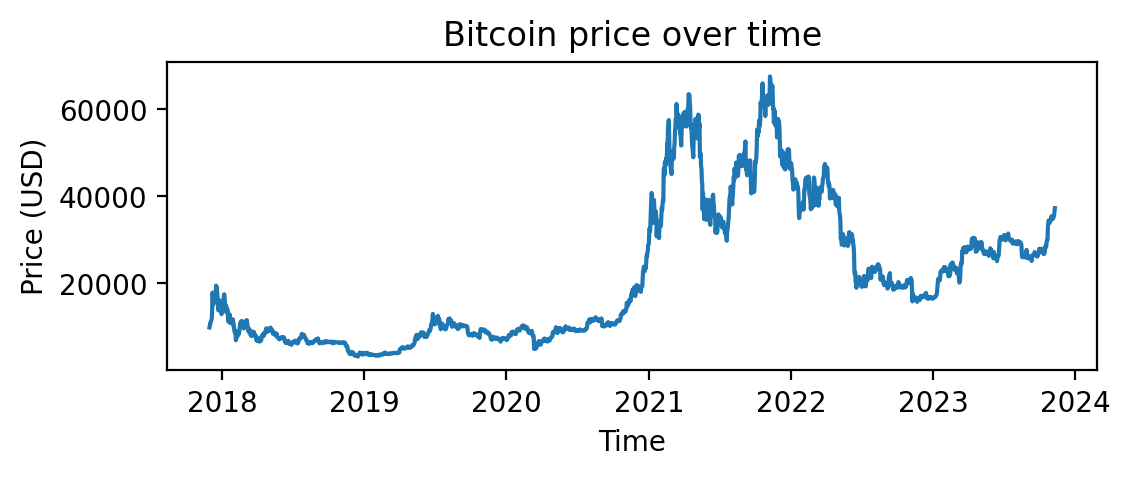

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,2)

plt.plot(df['Close'])
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();

Давайте выведим график в более симпатичном виде.

In [ ]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 851.4 kB/s eta 0:00:00


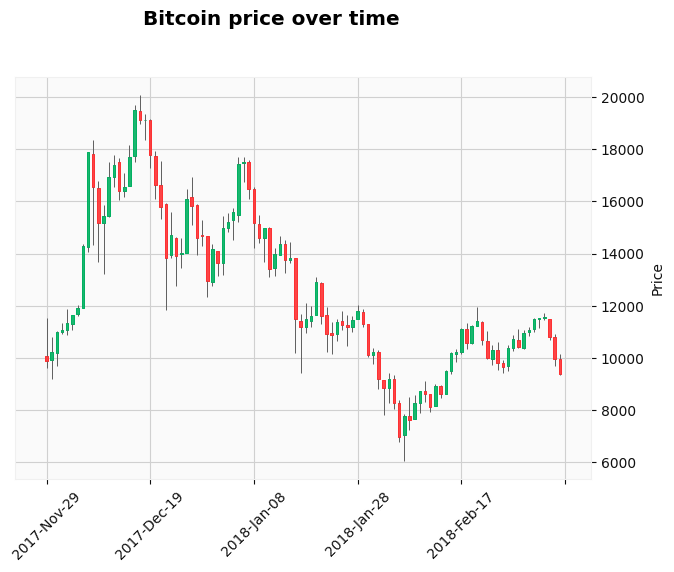

In [ ]:
import mplfinance as mpf

mpf.plot(df[:100], type='candle', style='yahoo', title='Bitcoin price over time')

Выделим признаки и целевую переменную.
Здесь представлена относительно небольшая часть данных.

In [ ]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((2173, 4), (2173,))

**Нормировка**

Явного тренда не наблюдается. Поэтому только стандартизуем признаки.
Целевая переменная также варьируется в широком диапазоне.

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_trans = ss.fit_transform(X)

#from # Your code here
ss_y = StandardScaler()
y_trans = ss_y.fit_transform(y.reshape(-1,1)).reshape(-1)

Требуется подать в модель 100 значений до текущего дня и спрогнозировать следующие 50 значений временного шага.

Требуется получать 100 выборок из X, брать 50 следующих индексов в y и их объединять.

In [ ]:
# split a multivariate sequence into samples

def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    j = 0
    X, y = list(), list() # instantiate X and y
    for i in range(n_steps_in, input_sequences.shape[0] - n_steps_out):
        X.append(input_sequences[i-n_steps_in: i])
        y.append(output_sequence[i: i+n_steps_out])
    return np.array(X), np.array(y)

In [ ]:
X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(2023, 100, 4) (2023, 50)


Давайте проверим, что первая выборка в y_mm действительно начинается с сотой выборки в исходном целевом векторе y.

In [ ]:
print(y_mm[0][0])
print(y_trans[100])

-0.7506530951244921
-0.7506530951244921


Будем предсказывать данные на несколько месяцев вперед.

Возьмём для обучения 90% данных, на тест - 10%. Как раз их и требуется предсказать.

In [ ]:
train_size = int(len(y) * 0.8)

X_train = X_ss[:train_size]
y_train = y_mm[:train_size]

X_test = X_ss[train_size:]
y_test = y_mm[train_size:]


In [ ]:
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (1738, 100, 4) (1738, 50)
Testing Shape: (285, 100, 4) (285, 50)


Переведём данные в тензоры для подачи в модель.

In [ ]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

В зависимости от того, как вы организуете данные и модель, вам может потребоваться привести данные к такой форме, которую сможет принять модель. Используйте torch.reshape

In [ ]:
# reshaping to rows, timestamps, features
# Your code here
X_train_tensors_final = X_train_tensors
X_test_tensors_final = X_test_tensors

In [ ]:
print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([1738, 100, 4]) torch.Size([1738, 50])
Testing Shape: torch.Size([285, 100, 4]) torch.Size([285, 50])


**Модель LSTM**

Вы можете реализовать модель как через слой `LSTM`, так и через `LSTMCell`.

Возможно, вам будет полезен параметр `dropout` в этих слоях.

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
            )
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        out, (h, m) = self.lstm(x)
        y = self.fc(out)
        return y

**Обучение**

Реализуйте цикл обучения.

В качестве loss-функции вы можете использовать как обычный MSE, так и что-то более подходящее на ваш взгляд.

In [ ]:
device = 'cpu'
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):

    for epoch in range(n_epochs):
        lstm.train()

        avg_train_loss = 0
        X_train = X_train.to(device)
        Y_pred = lstm(X_train)[:,-1,:]

        loss = loss_fn(Y_pred.flatten(), y_train.flatten())
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        if epoch % 25 == 0:
            print('* Epoch %d/%d' % (epoch+1, n_epochs))
            print('avg train loss: %f' % loss)

            lstm.eval()
            with torch.no_grad():
                X_test = X_test.to(device)
                Y_pred = lstm(X_test)[:,-1,:]

                loss = loss_fn(Y_pred.flatten(), y_test.flatten())
                print('avg val loss: %f' % loss)



Задайте параметры сети.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 101 # 1000 epochs
learning_rate = 0.01 # Your code here

# Your code here
input_size = 4
hidden_size = 32
num_layers = 1

num_classes = 50


lstm = LSTM(num_classes=num_classes, input_size=input_size,
            hidden_size=hidden_size, num_layers=num_layers)


Задайте loss-функцию и оптимизатор. Отметьте, что вам нужен loss для регрессии.

In [ ]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

Запустите цикл обучения

In [ ]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

* Epoch 1/101
avg train loss: 1.202237
avg val loss: 0.157487
* Epoch 26/101
avg train loss: 0.129048
avg val loss: 0.175750
* Epoch 51/101
avg train loss: 0.106615
avg val loss: 0.064646
* Epoch 76/101
avg train loss: 0.096585
avg val loss: 0.039003
* Epoch 101/101
avg train loss: 0.084817
avg val loss: 0.042722


**Предсказание**

Обратите внимание на то, что вы передаёте в модель. И так ли эти данные выглядят, как те, на которых модель училась.

Постройте график предсказания для всего набора данных.

In [ ]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = ss_y.transform(df.Close.values.reshape(-1, 1)) # old transformers

# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)

# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)

# reshaping the dataset
#df_X_ss = # Your code here

# forward pass
#train_predict = # Your code here
with torch.no_grad():
    data_predict = lstm(df_X_ss)
dataY_plot = df_y_mm


data_predict = ss_y.inverse_transform(data_predict) # reverse transformation
dataY_plot = ss_y.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_size, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

ValueError: ignored

Как вам результат?

Если вы подали достаточно данных, и если смотрите не слишком далеко за красную линию, вы должны увидеть, что **ваша модель удивительно точна** в прогнозировании цены на несколько месяцев вперед.


Однако то, что здесь происходит, является **утечкой данных**: информация о таргетах просочилась в тестовые признаки.


 То есть всякий раз, когда мы запускаем модель, она имеет доступ к цене открытия на этот день, которая, очевидно, будет очень близка к цене в конечном итоге для этого конкретного временного шага. Когда мы перебираем наши прогнозы по модели, мы добавляем первое предсказанное значение для этого временного шага. Это означает, что каждое предсказание, которое мы здесь строим, имеет то преимущество, что оно является следующим предсказанным значением, а не последовательностью из 50 значений в будущем.

**Как надо:** передать 100 временных шагов перед последним значением в тесте, а затем использовать **один раз** `forward` модели, чтобы предсказать следующие 50 временных шагов.

In [ ]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

In [ ]:
plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.legend()
plt.savefig("small_plot.png", dpi=300)
plt.show();

Хорошим результатом будет является, если реальные и предсказанные значения имеют один тренд.


В качестве последнего графика давайте посмотрим на масштаб данных.

**Настройте этот масштаб под ваши данные!**

In [ ]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(2100, len(y))]
plt.plot(a, y[2100:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.savefig("final_plot.png", dpi=300)
plt.show()

Ваш результат отчётливо зависит от того среда от данных, который вы используете.

Т.е. от того, не поменял ли ряд свой профиль после красной линии.



**Дополнительно**

* Взять больше исторических данных и попробовать улучшить свою модель. А также проверить её на различных участках ряда.

* Реализовать кросс-валидацию на временных рядах

## Формат результата

График с предсказанием, численная метрика оценки качества предсказания



<center><img src ="https://imageup.ru/img145/4642815/ts_prediction.png" width="500"></center>

# Задание 4*. Посимвольная генерация текста

Возьмите произведение Гете "Фауст" и обучите на нем LSTM модель для посимвольной генерации текста. Вместо one-hot кодирования используйте `nn.Embedding` [ссылка](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) [ссылка](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html). При обучении игнорируйте знаки препинания и номера страниц.


In [ ]:
import math
import random
from collections import Counter

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
set_random_seed(42)

In [ ]:
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Faust.txt

In [ ]:
with open("Faust.txt") as text_file:
    faust_text = "".join(text_file.readlines())

In [ ]:
# Your code here

## Формат результата

Сгенерерированный текст

Пример текста:

"все все от бесстыдные старой

все в нем получше все стремленья

поддержки с собой в сердце воздух своей

и в вечной страсти восстанет свой предлог

привет вам слуга в сладком страшней стране

и в мире все вражда станет станет

в поле на пользу своим воспоминанья"
